In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import gcsfs
from io import BytesIO

In [25]:
path = []
filepath = 'C:/Users/koust_fiminqv/Desktop/thesis/image_data/'
for root, dirs, files in os.walk(filepath):
    for file in files:
        path.append(os.path.join(root, file))

In [26]:
df = pd.DataFrame(path, columns=['path'])

In [27]:
image = Image.open(df.path[0])

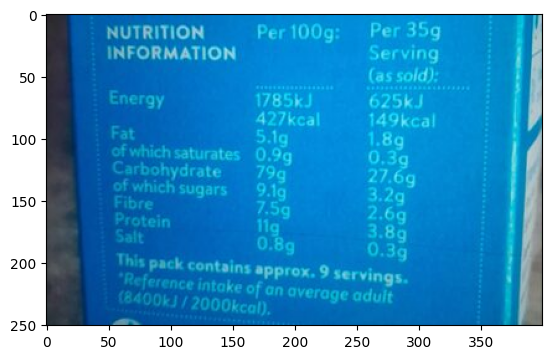

In [28]:
plt.imshow(image)
plt.show()

In [29]:
def get_image_shape(image_path):
    with Image.open(image_path) as img:
        return img.size
    
for i in range(0,5):
    image_path = df['path'].iloc[i]
    image_shape = get_image_shape(image_path)
    print(f"Image {i+1} shape: {image_shape}")

Image 1 shape: (400, 251)
Image 2 shape: (400, 215)
Image 3 shape: (400, 255)
Image 4 shape: (300, 400)
Image 5 shape: (400, 221)


In [30]:
min_width = float('inf')
min_height = float('inf')

for image_path in df['path']:
    try:
        width, height = get_image_shape(image_path)
        if width < min_width:
            min_width = width
        if height < min_height:
            min_height = height
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [31]:
print(f"Minimum width: {min_width}")
print(f"Minimum height: {min_height}")

Minimum width: 72
Minimum height: 55


In [32]:
def resize_image(image_path, target_size=(224, 224)):
    try:
        with Image.open(image_path) as img:
            img_resized = img.resize(target_size)
            return img_resized
    except Exception as e:
        print(f"Error resizing {image_path}: {e}")
        return None

In [38]:
target_size = (224, 224)
resized_images = []
for image_path in df['path']:
    resized_img = resize_image(image_path, target_size)
    if resized_img is not None:
        resized_images.append(resized_img)

In [39]:
output_dir = 'resized_images'
os.makedirs(output_dir, exist_ok=True)
for i, resized_img in enumerate(resized_images):
    img_name = f"resized_image_{i}.jpg"
    img_path = os.path.join(output_dir, img_name)
    resized_img.save(img_path)

In [4]:
df = pd.read_csv('labeled_data.csv')

In [5]:
df.label[0]

'[{"x":9.587217043941411,"y":1.7310252996005324,"width":74.30093209054594,"height":77.49667110519309,"rotation":0,"rectanglelabels":["Nutri_Table"],"original_width":224,"original_height":224}]'

In [6]:
import json
data = {
    "path": [],
    "x": [],
    "y": [],
    "height": [],
    "width": []
}

for _, row in df.iterrows():
    path = row['image']
    labels = json.loads(row['label'])
    
    for label in labels:
        ow = label['original_width']
        oh = label['original_height']
        data['path'].append(path)
        x = label['x'] / 100.0 * ow
        y = label['y'] / 100.0 * oh
        w = label['width'] / 100.0 * ow
        h = label['height'] / 100.0 * oh
        data['x'].append(x)
        data['y'].append(y)
        data['height'].append(h)
        data['width'].append(w)


In [7]:
df = pd.DataFrame(data)

In [8]:
df.head()

,path,x,y,height,width
0,gs://nutri_image_data/resized_images/resized_i...,21.475366,3.877497,173.592543,166.434088
1,gs://nutri_image_data/resized_images/resized_i...,32.213049,25.352863,196.559254,173.592543
2,gs://nutri_image_data/resized_images/resized_i...,26.844208,33.406125,170.311585,175.083888
3,gs://nutri_image_data/resized_images/resized_i...,38.476698,28.335553,158.977364,170.908123
4,gs://nutri_image_data/resized_images/resized_i...,1.193076,90.375499,112.745672,212.964048


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=23011475)

In [11]:
train_df.reset_index(inplace=True)
train_df.head()

,index,path,x,y,height,width
0,10,gs://nutri_image_data/resized_images/resized_i...,0.894807,0.894807,147.941411,223.105193
1,758,gs://nutri_image_data/resized_images/resized_i...,22.966711,56.074567,40.266312,197.155792
2,41,gs://nutri_image_data/resized_images/resized_i...,22.966711,42.055925,167.627164,189.400799
3,673,gs://nutri_image_data/resized_images/resized_i...,21.773635,50.705726,113.640479,199.541944
4,374,gs://nutri_image_data/resized_images/resized_i...,14.316911,16.404794,197.752330,201.033289


In [12]:
train_df.drop('index', axis=1, inplace=True)
train_df.head()

,path,x,y,height,width
0,gs://nutri_image_data/resized_images/resized_i...,0.894807,0.894807,147.941411,223.105193
1,gs://nutri_image_data/resized_images/resized_i...,22.966711,56.074567,40.266312,197.155792
2,gs://nutri_image_data/resized_images/resized_i...,22.966711,42.055925,167.627164,189.400799
3,gs://nutri_image_data/resized_images/resized_i...,21.773635,50.705726,113.640479,199.541944
4,gs://nutri_image_data/resized_images/resized_i...,14.316911,16.404794,197.752330,201.033289


In [13]:
test_df.reset_index(inplace=True)
test_df.head()

,index,path,x,y,height,width
0,347,gs://nutri_image_data/resized_images/resized_i...,31.019973,11.035952,193.874834,167.030626
1,737,gs://nutri_image_data/resized_images/resized_i...,2.684421,54.583222,141.081225,102.306258
2,675,gs://nutri_image_data/resized_images/resized_i...,8.351531,2.684421,216.245007,205.209055
3,582,gs://nutri_image_data/resized_images/resized_i...,0.894807,46.231691,108.868176,223.105193
4,305,gs://nutri_image_data/resized_images/resized_i...,0.596538,3.280959,172.101198,221.017310


In [14]:
test_df.drop('index', axis=1, inplace=True)
test_df.head()

,path,x,y,height,width
0,gs://nutri_image_data/resized_images/resized_i...,31.019973,11.035952,193.874834,167.030626
1,gs://nutri_image_data/resized_images/resized_i...,2.684421,54.583222,141.081225,102.306258
2,gs://nutri_image_data/resized_images/resized_i...,8.351531,2.684421,216.245007,205.209055
3,gs://nutri_image_data/resized_images/resized_i...,0.894807,46.231691,108.868176,223.105193
4,gs://nutri_image_data/resized_images/resized_i...,0.596538,3.280959,172.101198,221.017310


In [15]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/koust_fiminqv/Desktop/thesis/sharp-imprint-420622-2c80106b20eb.json'

In [16]:
def load_and_preprocess_image(path):
    fs = gcsfs.GCSFileSystem(project='sharp-imprint-420622')
    path = path.replace("gs://", "")
    with fs.open(path, 'rb') as f:
        img_bytes = f.read()
        img = load_img(BytesIO(img_bytes), target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0 
        return img_array

In [17]:
X_train = np.array([load_and_preprocess_image(path) for path in train_df['path']])
X_test = np.array([load_and_preprocess_image(path) for path in test_df['path']])

In [18]:
y_train = train_df[['x', 'y', 'height', 'width']].values
y_test = test_df[['x', 'y', 'height', 'width']].values

In [19]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4)
])

In [52]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [53]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
22/22 [==============================] - 29s 1s/step - loss: 4392.9814 - val_loss: 2431.6912
Epoch 2/20
22/22 [==============================] - 26s 1s/step - loss: 1980.7964 - val_loss: 1858.7809
Epoch 3/20
22/22 [==============================] - 26s 1s/step - loss: 1700.8142 - val_loss: 1798.0460
Epoch 4/20
22/22 [==============================] - 26s 1s/step - loss: 1729.2812 - val_loss: 1679.3735
Epoch 5/20
22/22 [==============================] - 26s 1s/step - loss: 1580.1143 - val_loss: 1617.7637
Epoch 6/20
22/22 [==============================] - 26s 1s/step - loss: 1500.9026 - val_loss: 1530.6837
Epoch 7/20
22/22 [==============================] - 26s 1s/step - loss: 1380.5632 - val_loss: 1425.9199
Epoch 8/20
22/22 [==============================] - 26s 1s/step - loss: 1499.4138 - val_loss: 1563.1824
Epoch 9/20
22/22 [==============================] - 26s 1s/step - loss: 1291.2660 - val_loss: 1380.5070
Epoch 10/20
22/22 [==============================] - 26s 1s/step

In [77]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

6/6 [==============================] - 1s 231ms/step - loss: 212.9453
Test Loss: 212.94525146484375


In [55]:
predictions = model.predict(X_test)

6/6 [==============================] - 1s 227ms/step


In [80]:
for i in range(5):
    print(f"{i}:True: {y_test[i]}, Predicted: {predictions[i]}")

0:True: [13.8482024   4.92676431 86.55126498 74.56724368], Predicted: [12.998085  4.443158 92.32477  82.87969 ]
1:True: [ 1.19840213 24.36750999 62.98268975 45.67243675], Predicted: [ 3.3897913 25.02367   50.212807  80.13665  ]
2:True: [ 3.72836218  1.19840213 96.5379494  91.61118509], Predicted: [ 4.0688844 12.988485  80.53201   91.44157  ]
3:True: [ 0.39946738 20.6391478  48.60186418 99.60053262], Predicted: [ 8.635299 13.364807 60.938408 76.80548 ]
4:True: [ 0.26631158  1.46471372 76.83089214 98.66844208], Predicted: [ -4.276853  11.58197   92.765015 107.63102 ]


In [46]:
def display_image_with_bbox(image, bbox):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[3], bbox[2], 
                                      linewidth=2, edgecolor='r', facecolor='none'))
    plt.axis('off')
    plt.show()

In [47]:
def load_and_preprocess_testimage(path, target_size=(224, 224)):
    fs = gcsfs.GCSFileSystem(project='sharp-imprint-420622')
    path = path.replace("gs://", "")
    with fs.open(path, 'rb') as f:
        img_bytes = f.read()
        img = load_img(BytesIO(img_bytes), target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  
        return img, img_array

In [58]:
img,img_array = load_and_preprocess_testimage(test_df.path[0])

In [57]:
actual_bounding_box = [test_df.x[0], test_df.y[0], test_df.height[0], test_df.width[0]]

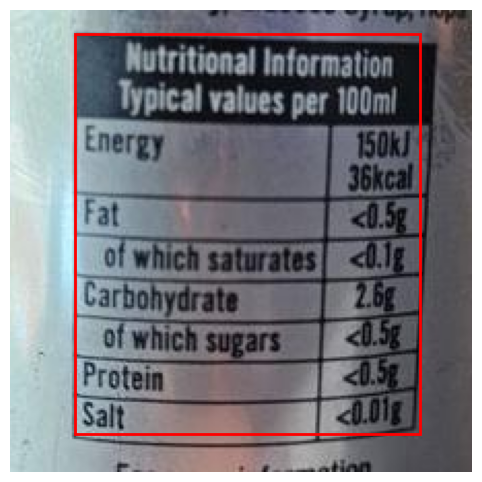

In [59]:
display_image_with_bbox(img, actual_bounding_box)

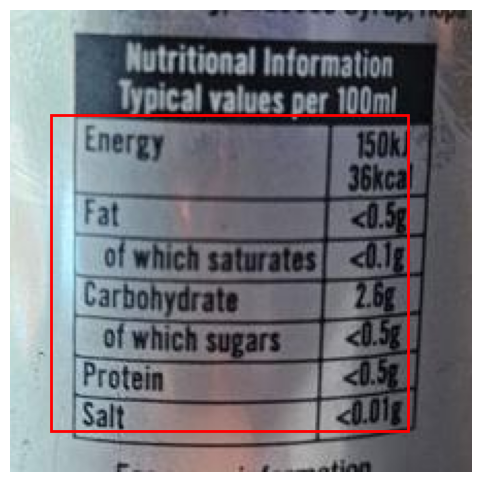

In [60]:
display_image_with_bbox(img, predictions[0])

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

model = EfficientNetV2S(weights='imagenet', 
                         include_top=False,
                         input_shape=(224, 224, 3))

In [ ]:
for layer in model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

my_model = Sequential([model,
                       GlobalAveragePooling2D(),
                       Dense(64, activation='relu')])

my_model.summary()